## Week 3-1: Lasso regression

#### Announcement
* HW1 posted
* Group list due this Sunday @ midnight

#### Last time
* Ridge regression

#### Today
* Lasso regression
* LARS

#### References

- ESL, Chapter 3
- James Sharpnack's lecture notes
- Robert Tibshirani (1996). Regression Shrinkage and Selection via the Lasso. _JRSSB_ 58:267--288
- Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004). Least Angle Regression. _AOS_ 32:407--451

### Lasso 

<img src="lasso.png" style="width: 600px;"/>

Lasso, short for 'least absolute selection operator', which shrinks some coefficients and sets others to 0, hence tries to retain the good features of both subset selection and ridge regression.

$$\min_{\beta \in \mathbb{R}^p} \left\{ \|Y - X\beta\|_2^2 + \lambda \|\beta\|_1 \right\},$$

where $\|\beta\| = \sum_{j=1}^p |\beta_j|$

### Why the lasso will often produce coefficients that are exactly 0?

<img src="lasso-solution.png" style="width: 600px;"/>


From Robert Tibshirani (1996):

Consider $p = 2$

- The elliptic contours are the function $(\beta - \hat\beta)'X'X(\beta - \hat \beta)$, $\hat \beta$ the OLS estimator. The contours are centered at $\hat \beta$. 
- The constraint regions are $|\beta_1|+|\beta_2| \leq t$ in (a) and $\beta_1^2 + \beta_2^2 \leq t$ in (b)
- In Fig. 2(a): The lasso solution is the first place that the contours touch the square, and this will sometimes occur at a corner, corresponding to a zero coefficient. 
- The picture for ridge regression is shown in Fig. 2(b): there are no corners for the contours to hit and hence zero solutions will rarely result.



### Bias and variance

The bias and variance of lasso regression estimates behave in the same general manner as they did for ridge regression. The bias increases as $\lambda$ (amount of shrinkage) increases, and the variance decreases as $\lambda$ (amount of shrinkage) increases.

<table><tr>
<td> <img src="bias-variance.png" style="width: 300px;"/> </td>
<td> <img src="mse.png" style="width: 300px;"/> </td>
</tr></table>

(Source: [Ryan Tibshirani's notes](https://www.stat.cmu.edu/~ryantibs/advmethods/notes/highdim.pdf))

### Degrees of freedom

Degrees of freedom is a way of quantifying the effective number of parameters used by a fitting procedure.

#### Linear regression 
In usual linear regression setting, the degrees of freedom of a model is the number of free parameters $p$.

#### Ridge regression

In ridge regression, we define the _effective degress of freedom_ as 
$$
df(\lambda) = \text{tr}[X(X'X + \lambda I_p)^{-1} X'] = \sum_{j=1}^p \frac{d_j^2}{d_j^2 + \lambda},
$$
which is a monotone decreasing function of $\lambda$. 

- when $\lambda = 0$, the effective degrees of freedom is $p$;
- when $\lambda \to \infty$, the effective degress of freedom $\to 0$.


#### Lasso regression 

In lasso, the degrees of freedom is the number of nonzero components in $\hat\beta_{\text{lasso}}$.

### How to choose $\lambda$?

Most popular approach is to use cross-validation to choose $\lambda$ and then apply the one standard error rule

- Consider a set of values of $\lambda = \{\lambda_1, \dots, \lambda_m\}$
- For each $\lambda$, perform $K$-fold cross validation and compute the prediction error
$$
\text{CVErr}(\hat \beta_{\text{lasso}}(\lambda)) 
= \frac{1}{K} \sum_{k=1}^K \text{PreErr}_k ((\hat \beta_{\text{lasso}})^{-(k)})
$$
- Pick the tunning parameter $\hat \lambda$ from the usual error rule:
$$
\hat \lambda = \min_{\lambda \in \{\lambda_1, \dots, \lambda_m\}} \text{CVErr}(\hat \beta_{\text{lasso}}(\lambda)) 
$$
- We can achieve smaller, simpler models with comparable predictive performance by using _the one standard error rule_:
    1. Compute the cross-validation standard error:
    $$
     \text{SE}(\text{CVErr}(\hat \beta_{\text{lasso}}(\lambda)))
     = \frac{1}{\sqrt{K}} \text{sd} \left(
         \text{PreErr}_1 ((\hat \beta_{\text{lasso}})^{-(1)}),
         \dots,
         \text{PreErr}_K ((\hat \beta_{\text{lasso}})^{-(K)})
     \right)
    $$
    2. Choose $\hat \lambda_{\text{lasso}}$ such that 
    $$
    \hat \lambda_{\text{lasso}} = \max\{\lambda \in \{\lambda_1, \dots, \lambda_m\}, \quad 
        \text{CVErr}(\hat \beta_{\text{lasso}}(\lambda)) \leq 
        \text{CVErr}(\hat \beta_{\text{lasso}}(\hat \lambda)) + \text{SE}(\text{CVErr}(\hat \beta_{\text{lasso}}(\hat\lambda)))\}
    $$

<img src="rule.png" style="width: 500px;"/>

Example: $n$ = 50, $p$ = 30, 10 truly large coefficients, 20 zero coefficients. The one standard error rule chooses a model with 15 variables, whereas the usual rule chooses a model with 20.

### Orthogonal design

Under the orthogonal design $X'X = I_p$, lasso estimation can be simplified as solving 
$$
\hat \beta_j = \min_{\beta_j} \left\{
\frac{1}{2} (\hat \beta_j^{OLS} - \beta_j)^2 + \lambda |\beta_j|
\right\}
$$

Then the lasso estimator is given by 
$$
\hat \beta_j = S(\hat \beta_j^{OLS}, \lambda),
$$
where 
$S(z, \lambda) = \text{sgn}(z)(|z| - \lambda)_+$, $\text{sgn}(z)$ is the sign of $z$.

It performs the so-called _soft thresholding_

<img src="soft-th.png" style="width: 500px;"/>

### Wavelet denoising

Soft thresholding is commonly used for orthonormal bases.  
- Suppose that we have a vector $y_1,\ldots, y_T$ (like a time series).
- And we want to reconstruct $y$ with $W \beta$ where $\beta$ has a small sum of absolute values $\sum_i |\beta_i|$ 
- $W$ is $T \times T$ and $W W^\top = W^\top W = I$ (orthonormal full rank design)

Want to minimize 
$$
\frac 12 \sum_{j=1}^T (y - W \beta)_j^2 + \lambda \sum_{j=1}^T |\beta_j|.
$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
## Explore Turkish stock exchange dataset

tse = pd.read_excel('../data/data_akbilgic.xlsx',skiprows=1)

tse = tse.rename(columns={'ISE':'TLISE','ISE.1':'USDISE'})

In [3]:
tse.head

<bound method NDFrame.head of           date     TLISE    USDISE        SP       DAX      FTSE    NIKKEI  \
0   2009-01-05  0.035754  0.038376 -0.004679  0.002193  0.003894  0.000000   
1   2009-01-06  0.025426  0.031813  0.007787  0.008455  0.012866  0.004162   
2   2009-01-07 -0.028862 -0.026353 -0.030469 -0.017833 -0.028735  0.017293   
3   2009-01-08 -0.062208 -0.084716  0.003391 -0.011726 -0.000466 -0.040061   
4   2009-01-09  0.009860  0.009658 -0.021533 -0.019873 -0.012710 -0.004474   
..         ...       ...       ...       ...       ...       ...       ...   
531 2011-02-16  0.008599  0.013400  0.006238  0.001925  0.007952  0.005717   
532 2011-02-17  0.009310  0.015977  0.003071 -0.001186  0.000345  0.002620   
533 2011-02-18  0.000191 -0.001653  0.001923  0.002872 -0.000723  0.000568   
534 2011-02-21 -0.013069 -0.013706 -0.020742 -0.014239 -0.011275  0.001358   
535 2011-02-22 -0.007246 -0.019442  0.000000 -0.000473 -0.002997 -0.017920   

      BOVESPA        EU        EM

In [4]:
tse.shape # check dimension

(536, 10)

In [5]:
def const_wave(T,a,b):
    wave = np.zeros(T)
    s1 = (b-a) // 2
    s2 = (b-a) - s1
    norm_C = (s1*s2 / (s1+s2))**0.5
    wave[a:a+s1] = norm_C / s1
    wave[a+s1:b] = -norm_C / s2
    return wave

In [6]:
def _const_wave_basis(T,a,b):
    if b-a < 2:
        return []
    wave_basis = []
    wave_basis.append(const_wave(T,a,b))
    mid_pt = a + (b-a)//2
    wave_basis += _const_wave_basis(T,a,mid_pt)
    wave_basis += _const_wave_basis(T,mid_pt,b)
    return wave_basis

In [7]:
def const_wave_basis(T,a,b):
    father = np.ones(T) / T**0.5
    return [father] + _const_wave_basis(T,a,b)

In [8]:
# Construct discrete Haar wavelet basis
T,p = tse.shape
wave_basis = const_wave_basis(T,0,T)
W = np.array(wave_basis).T

In [1]:
_ = plt.plot(W[:,:4])

NameError: name 'plt' is not defined

In [10]:
def soft(y,lamb):
    pos_part = (y - lamb) * (y > lamb)
    neg_part = (y + lamb) * (y < -lamb)
    return pos_part + neg_part

In [11]:
## Volatility seems most interesting
## will construct local measure of volatility
## remove rolling window estimate (local centering)
## square the residuals

tse = tse.set_index('date')
tse_trem = tse - tse.rolling("7D").mean()
tse_vol = tse_trem**2.

## Make wavelet transformation and soft threshold

tse_wave = W.T @ tse_vol.values
lamb = .001
tse_soft = soft(tse_wave,lamb)
tse_rec = W @ tse_soft # reconstruct tse
tse_den = tse_vol.copy()
tse_den.iloc[:,:] = tse_rec

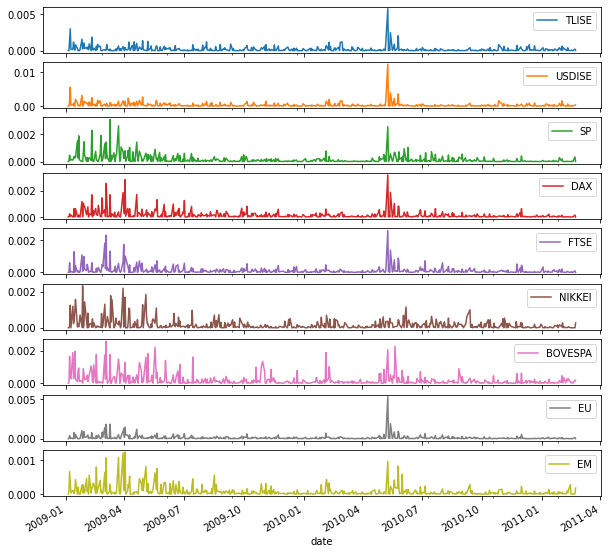

In [12]:
_ = tse_vol.plot(subplots=True,figsize=(10,10))

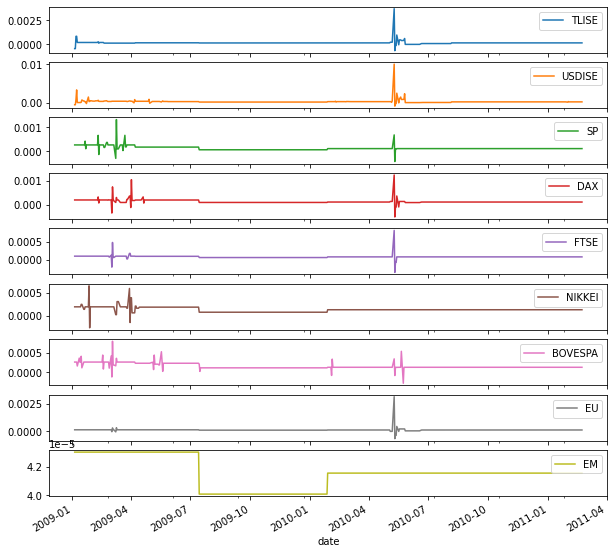

In [13]:
_ = tse_den.plot(subplots=True,figsize=(10,10))

### Wavelet reconstruction

Can reconstruct the sequence by
$$
\hat y = W \hat \beta.
$$
The objective is likelihood term + $\ell_1$ penalty term,
$$
\frac 12 \sum_{i=1}^T (y - W \beta)_i^2 + \lambda \sum_{i=1}^T |\beta_i|.
$$
> The $\ell_1$ penalty "forces" some $\beta_i = 0$, inducing sparsity

[  0   2  48  63 344 345]


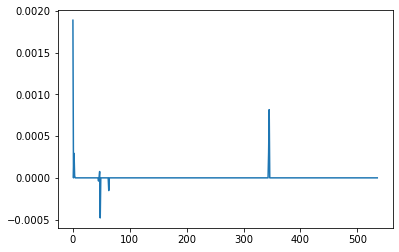

In [14]:
plt.plot(tse_soft[:,4])
high_idx = np.where(np.abs(tse_soft[:,4]) > .0001)[0]
print(high_idx)

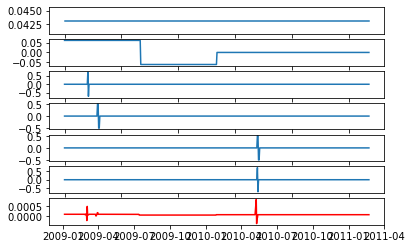

In [15]:
fig, axs = plt.subplots(len(high_idx) + 1,1)
for i, idx in enumerate(high_idx):
    axs[i].plot(W[:,idx])
plt.plot(tse_den['FTSE'],c='r')

### Lasso - non-orthogonal design

Recall that the objective is likelihood term + $\ell_1$ penalty term,
$$
\frac 12 \|y - X \beta\|^2 + \lambda \|\beta\|_1.
$$
does not have closed form for $X$ that is non-orthogonal.

- it is convex
- it is non-smooth (recall $|x|$)
- has tuning parameter $\lambda$

### Solving the Lasso

The lasso can be written in *regularized form*,
$$
\min_\beta \frac 12 \|y - X\beta\|^2 + \lambda \sum_{j=1}^p |\beta_j|,
$$
or in *constrained form*,
$$
\min_\beta \frac 12 \|y - X\beta\|^2, \quad \textrm{s.t.} \sum_{j=1}^p |\beta_j| \le t,
$$
for every $\lambda$ there is a $t$ such that the regularized form and constrained form have the same argmin

Algorithms:

    - Coordinate descent. 
    - Convex optimization algorithms. 
    - Least angle regression (LARS). See Efron et al. (2004).
    - Others

### Least Angle Regression (LAR/LARS)

1. Standardize predictors and start with residual $r = y - \bar y$, $\hat \beta = 0$
2. Find $x_j$ most correlated with $r$
3. Move $\beta_j$ in the direction of $x_j^\top r$ until the residual is more correlated with another $x_k$
4. Move $\beta_j,\beta_k$ in the direction of their joint OLS coefficients of $r$ on $(x_j,x_k)$ until some other competitor $x_l$ has as much correlation with the current residual
5. Continue until all predictors have been entered.

### Understanding LAR

Recall that we've learned forward stepwise regression. To add one variable at a time. At each step, identify the best variable to include in the model, and then update the least square fit sequentially.

LAR uses a similar idead but instead of exploiting the current variable at much as possible, LARS only fits the current variable to a certain level.

At first step, similar to the forward stepwise regression, identify the variable most correlated with the response.

Then, increase the coefficient for this variable: 

   - What happens here is that the correlation between this variable and the residual of the fit to decrease (as the coefficient slowly increases)
   - stop until another variable has the same absolute correlation (with the residual) as the current one. At this point, both variables are in the active set.

At each step when a new variable enters the active set, $\mathcal{S}$, slowly increase the coefficient of the variables in $\mathcal{S}$ along the direction of the least-square of the current residual on $\mathcal{S}$, i.e.
$$
\beta_\mathcal{S}(\alpha) = \beta_\mathcal{S}(0) + \alpha \delta_{\mathcal{S}},
$$
where $\delta_{\mathcal{S}} = (X_\mathcal{S}'X_\mathcal{S})^{-1} X_\mathcal{S}'r$, $r = y - X_\mathcal{S}\beta_\mathcal{S}(0)$.
$\beta_\mathcal{S}(0)$ is the coefficent vector for the variables in $\mathcal{S}$ at the step. There are $|S| - 1$ zero values.

   - Note that the variable which just entered the active set had coefficient 0.
   - The correlations between the variables in $\mathcal{S}$ and the residual $r(\alpha) = y − X_\mathcal{S} \beta_{\mathcal{S}}(\alpha)$ decrease at the same time as $\alpha$ increases
    
Increase $\alpha$, until there is another variable which has as much correlation with the residual $r(\alpha)$ as the ones in the active set $\mathcal{S}$, at which point, the new variable enters the active set and the iterations restart.    

   - At each iteration, there is a value for $\beta$. This corresponds to a value of $t = \|\beta\|_1$
   - At the very beginning, when there was no variable in the active set. One could consider $t = 0$, i.e., $\|\beta\|_1 = 0$ or $\lambda = \infty$
   - In the end, when all variables are in the active set. This corresponds to $t = \|\hat \beta^{OLS}\|_1$, i.e., $\lambda = 0$.
   
   
Further reading: https://b-thi.github.io/pdfs/LARS.pdf

<img src="projection.png" style="width: 500px;"/>

### LARS with lasso modification

4.5 If a non-zero coefficient drops to 0 then remove it from the active set and recompute the restricted OLS.

![](lars_lasso.png)
from ESL